## BAIT 509 Project
## Authors: Abhishek Ramesh, Kinjal Majumdar, Prasoon Mehta

The data contains the following features:-
1. GRE scores
2. TOEFL scores
3. University Rating
4. SOP ratings(on a scale of 5)
5. LOR ratings(on a scale of 5)
6. CGPA (on a scale of 10)
7. Research Experience(with experience = 1, no experience = 0)
6. Probability of an admit at a US university


This notebook contains:-
    1. Exploratory Data Analysis
    2. Linear SVM for different Chance.of.Admit cutoff values
    3. Radial SVM for different Chance.of.Admit cutoff values 
    4. Best cutoff based on least error values out of all models(Linear SVM, Radial SVM and Logistic Regression(done in .R in this folder) 


## Import all required packages

In [1]:
#Visualisation and Tabulation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import seaborn as sns
sns.set(color_codes=True)

#Ignore python related depreciation warnings
import warnings

#Machine learning model and evaluation methods

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV

#Ref: https://www.kaggle.com/anon7r/graduate-admissions-eda-and-linear-regression
#Ref: https://stackoverflow.com/questions/879173/how-to-ignore-deprecation-warnings-in-python

# Dataset Reference: Mohan S Acharya, Asfia Armaan, Aneeta S Antony :
# A Comparison of Regression Models for Prediction of Graduate Admissions,
# IEEE International Conference on Computational Intelligence in Data Science 2019

## Explanatory Data Analysis

In [2]:
#Read the dataset
grad_data = pd.read_csv("Admission_Predict_Ver1.1.csv")
#Drop Serial Number Column 
grad_data.drop(columns = 'Serial No.', inplace = True)

In [3]:
#Obtain dataset dimensions
grad_data.shape

(500, 8)

In [4]:
#Obtain summary of dataset
grad_data.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


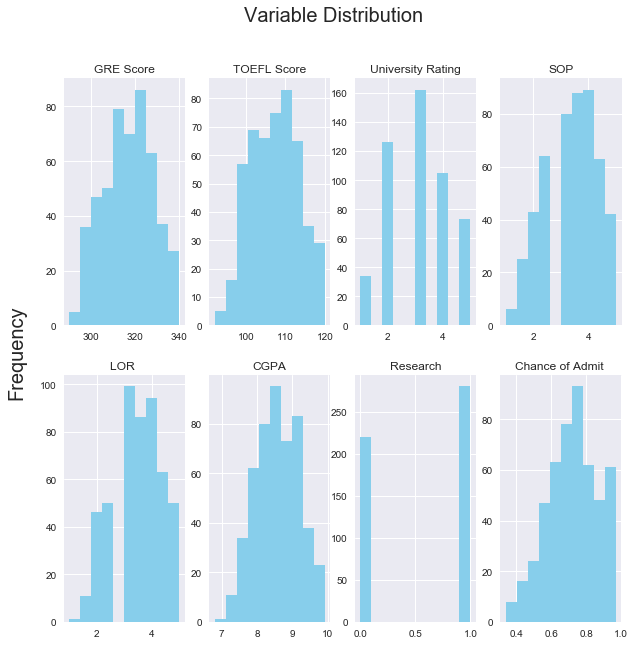

In [22]:
#Obtain the distribution of data points through histograms
hist,axes = plt.subplots(2,4)
hist.set_size_inches(10,10)
hist.text(0.06, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=20)
hist.suptitle("Variable Distribution", fontsize = 20)
hist_count = 0
for i in range(0,2):
    for j in range(0,4):
        axes[i,j].hist(grad_data.iloc[0:,hist_count], bins = 10, color = 'skyblue')
        axes[i,j].set_title(grad_data.columns[hist_count])
        hist_count += 1
  
plt.show()


In [6]:
# check for NA values
grad_data.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

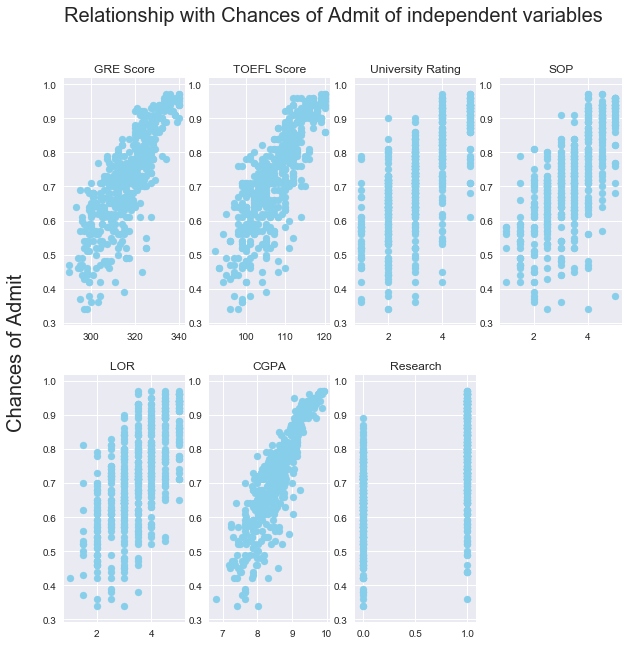

In [23]:
#Understand relationship between variables
#Obtain the distribution of data points through histograms
scatter,axes = plt.subplots(2,4)
scatter.set_size_inches(10,10)
scatter.text(0.06, 0.5, 'Chances of Admit', ha='center', va='center', rotation='vertical', fontsize=20)
scatter.suptitle("Relationship with Chances of Admit of independent variables", fontsize = 20)
scatter_count = 0
for i in range(0,2):
    for j in range(0,4):
        axes[i,j].scatter(grad_data.iloc[0:,scatter_count], grad_data.iloc[:,7], color = 'skyblue')
        axes[i,j].set_title(grad_data.columns[scatter_count])
        scatter_count += 1
plt.delaxes(axes[1,3])
plt.draw()

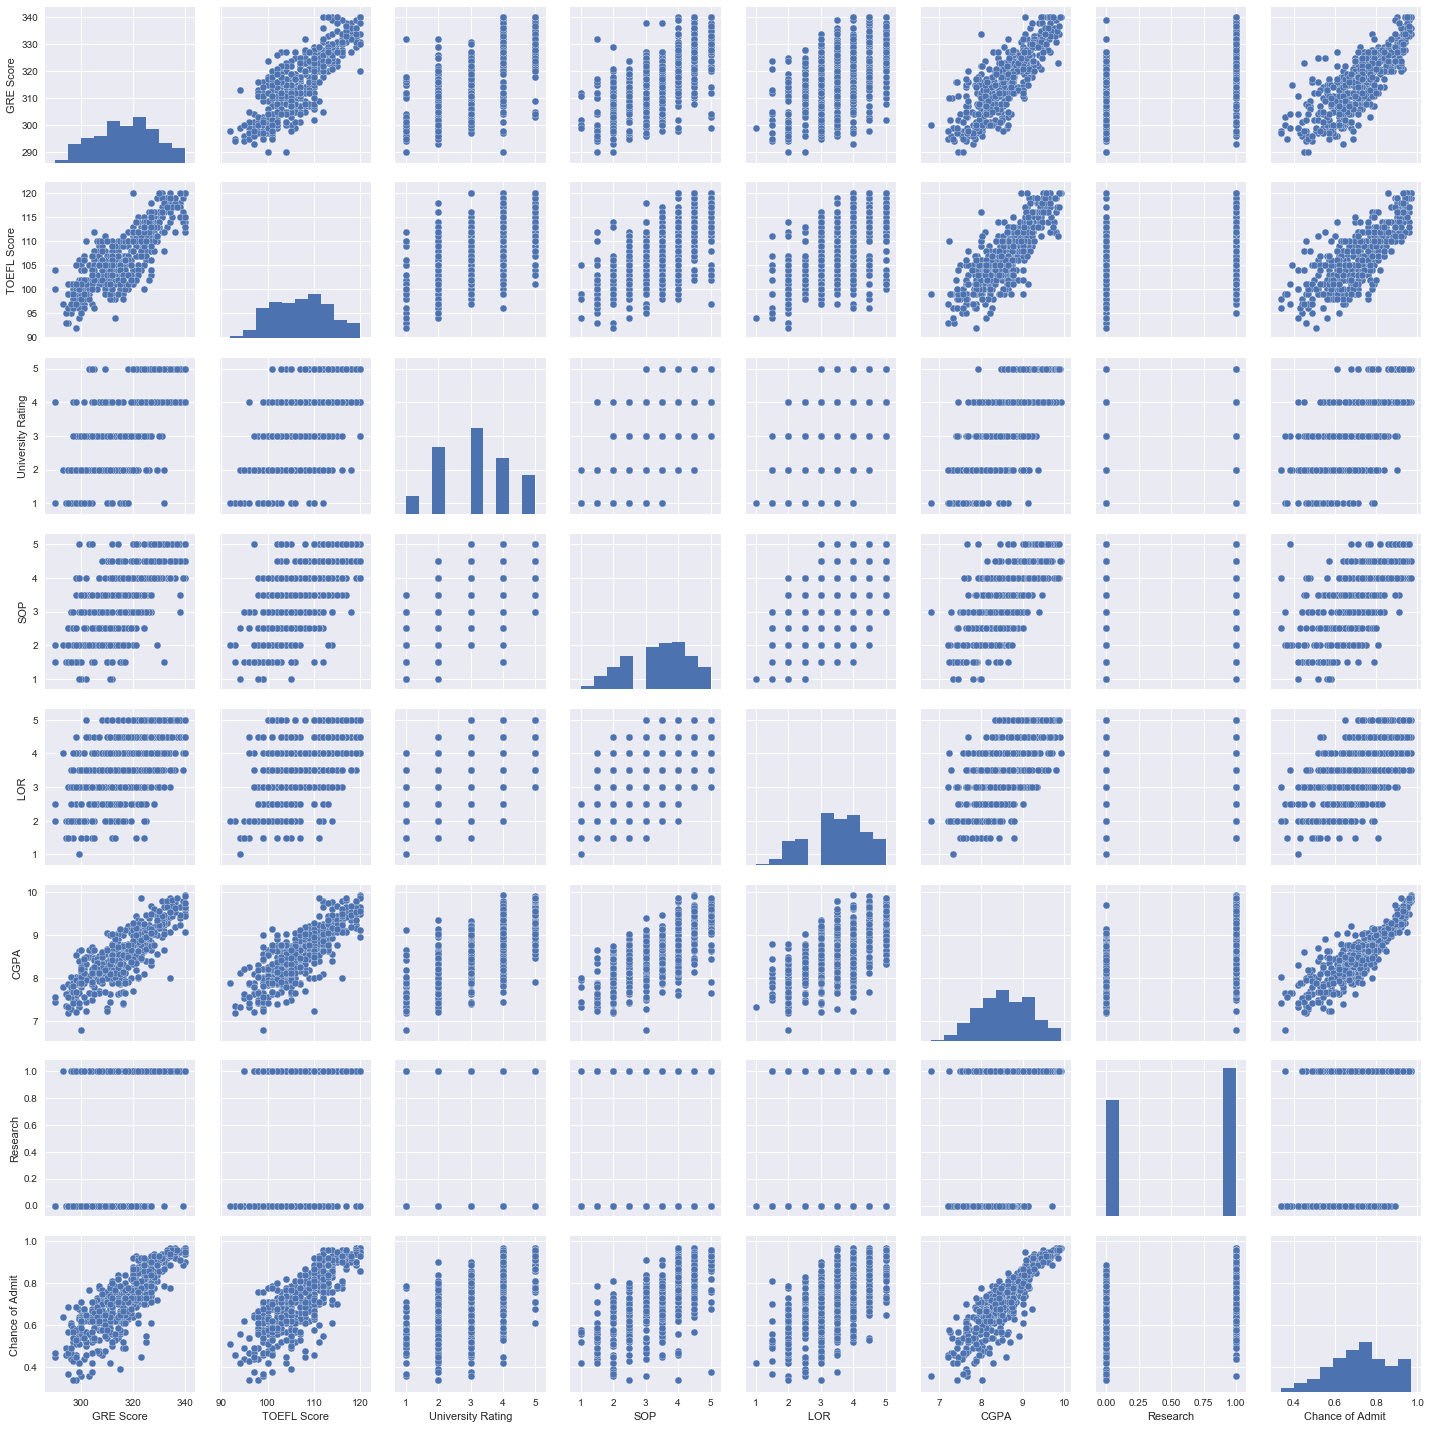

In [8]:
#Plot each variable against each other
grad_plot = grad_data
#grad_plot.drop(columns='Research', inplace = True)
sns.pairplot(grad_plot)
plt.show()

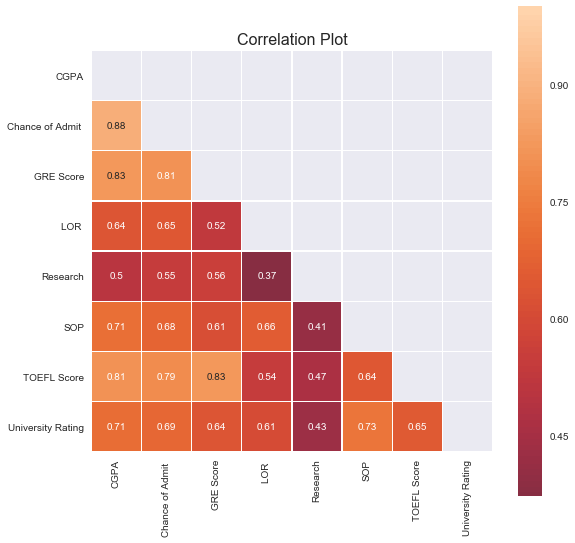

In [9]:
fig = plt.figure(figsize = (9,9))
corr_grad = grad_data[grad_data.columns.difference(['Chance.of.Admit'])].corr()
#corr_grad = grad_data.corr()

# We will only use the lower half to convey correlation and mask the upper right triangle of the square
mask = np.zeros_like(corr_grad, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate the correlation plot 
sns.heatmap(corr_grad, mask = mask, center=0, annot = True, square=True, linewidths=.5).set_title("Correlation Plot", fontsize = 16)

plt.show()

## Run linear SVM for different Chance.of.Admit cutoff values

In [10]:
warnings.filterwarnings("ignore", category=DeprecationWarning) #ignore python version depreciation warnings

#initialize lists
admit_pred_linear = []
admit_actual_linear = []
best_c_linear = []
best_error_linear = []
cutoff = []

#run linear SVM for different cutoff values on Chance of Admit
for k in np.arange(0.5, 1, 0.1):
    grad_data['Admit']=[1 if i>=k else 0 for i in grad_data.iloc[0:, 7]]
    Y = grad_data["Admit"]
    #print(Y)
    columns = grad_data.columns.tolist()[0:7]
    X = grad_data[columns]
    
    #Fitting an SVM Model
    scaler = StandardScaler()
    scaler.fit(X)
    Xscale = scaler.transform(X)
    linear_errors = []
    
    mysvm_linear = svm.SVC(kernel="linear")
    
    C = list(np.arange(1, 20, .5))
    linear_cv = GridSearchCV(mysvm_linear, param_grid={"C":C}, cv=10)
    linear_cv.fit(Xscale, Y)

    ##Cross - Validation for the Radial Model
    for lin in linear_cv.grid_scores_:
        linear_errors.append(1-lin[1]) #To obtain error rate for C values 1-10


    best_c_linear.append(linear_cv.best_params_["C"])
    best_error_linear.append(1 - linear_cv.best_score_)
    admit_pred_linear.append(sum(linear_cv.predict(Xscale)))
    admit_actual_linear.append(sum(Y))
    cutoff.append(k)

In [11]:
cutoff = pd.DataFrame(cutoff)
c_linear = pd.DataFrame(best_c_linear)
error_linear = pd.DataFrame(best_error_linear)
linear_table = pd.concat([cutoff, error_linear, c_linear], axis=1)
linear_table.columns = ["Cutoff", "Least Error Rate", "Corresponding C Values"]
linear_table

,Cutoff,Least Error Rate,Corresponding C Values
0,0.5,0.058,2.5
1,0.6,0.102,1.0
2,0.7,0.138,1.5
3,0.8,0.082,4.0
4,0.9,0.028,2.0


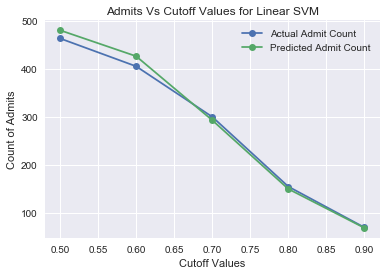

In [12]:
plt.plot(cutoff, admit_actual_linear, label = "Actual Admit Count", marker = 'o')
plt.plot(cutoff, admit_pred_linear, label = "Predicted Admit Count", marker = 'o')
plt.title("Admits Vs Cutoff Values for Linear SVM")
plt.xlabel('Cutoff Values')
plt.ylabel('Count of Admits')
plt.legend()
plt.show()

## Import Error table for logistic regression done in R

In [13]:
data = pd.read_csv("error_data_logistic.csv", sep = ' ')
cutoff = pd.DataFrame([0.5, 0.6, 0.7, 0.8, 0.9])
error_logistic = pd.DataFrame(data.iloc[0])
best_error_logistic = pd.DataFrame(list(error_logistic.values[0:5].flatten()))
table = pd.concat([cutoff, best_error_logistic], axis=1)
table.columns = ["Cutoff", "Least Error Rate"]
table

,Cutoff,Least Error Rate
0,0.5,0.048
1,0.6,0.090
2,0.7,0.126
3,0.8,0.072
4,0.9,0.018


## Radial SVM to predict Admit/No-Admit

## Run radial SVM for different Chance.of.Admit cutoff values

In [14]:
warnings.filterwarnings("ignore", category=DeprecationWarning)  #ignore python version depreciation warnings

#initialize lists
best_c_radial = []
best_gamma_radial = []
best_error_radial = []
cutoff = []
admit_pred_radial = []
admit_actual_radial = []


#run radial SVM for different cutoff values on Chance of Admit
for k in np.arange(0.5, 1.0, 0.1):
    radial_errors = [] #Create an empty list of errors for each cutoff value
    
    #Decide Admit/No Admit based on the cutoff k
    grad_data['Admit']=[1 if i>=k else 0 for i in grad_data.iloc[0:, 7]] 
    Y = grad_data["Admit"]
    columns = grad_data.columns.tolist()[0:7]
    X = grad_data[columns]
    
    #Scale the data predictors
    scaler = StandardScaler()
    scaler.fit(X)
    Xscale = scaler.transform(X)
    
    #Fit the Radial SVM
    mysvm_radial = svm.SVC(kernel="rbf")
    
    ##Cross - Validation for the Radial Model
    C = list(np.arange(1, 20, .5))
    gamma = [0.0001,.001,.01, 0.1]
    radial_cv = GridSearchCV(mysvm_radial, param_grid={"C":C, "gamma":gamma}, cv=10)
    radial_cv.fit(Xscale, Y)
    for rad in radial_cv.grid_scores_:
        radial_errors.append(1-rad[1]) #To obtain error rate for C values 1-20

    #Obtain best C values and the best error values for a given cutoff
    best_c_radial.append(radial_cv.best_params_["C"])
    best_gamma_radial.append(radial_cv.best_params_["gamma"])
    best_error_radial.append(1 - radial_cv.best_score_)
    admit_pred_radial.append(sum(radial_cv.predict(Xscale)))
    admit_actual_radial.append(sum(Y))
    cutoff.append(k)

In [15]:
cutoff = pd.DataFrame(cutoff)
c_radial = pd.DataFrame(best_c_radial)
gamma_radial = pd.DataFrame(best_gamma_radial)
error_radial = pd.DataFrame(best_error_radial)
table = pd.concat([cutoff , error_radial, c_radial, gamma_radial], axis=1)
table.columns = ["Cutoff", "Least Error Values", "Corresponding C values", "Corresponding Gamma values"]
table

,Cutoff,Least Error Values,Corresponding C values,Corresponding Gamma values
0,0.5,0.054,4.0,0.10
1,0.6,0.100,8.0,0.01
2,0.7,0.130,3.5,0.01
3,0.8,0.072,15.0,0.01
4,0.9,0.028,1.5,0.10


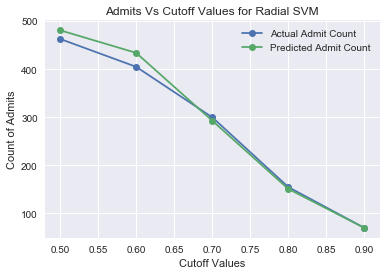

In [16]:
plt.plot(cutoff, admit_actual_radial, label = "Actual Admit Count", marker = 'o')
plt.plot(cutoff, admit_pred_radial, label = "Predicted Admit Count", marker = 'o')
plt.title("Admits Vs Cutoff Values for Radial SVM")
plt.xlabel('Cutoff Values')
plt.ylabel('Count of Admits')
plt.legend()
plt.show()

No handles with labels found to put in legend.


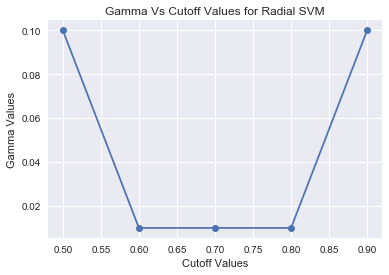

In [17]:
plt.plot(cutoff, gamma_radial, marker = 'o')
plt.title("Gamma Vs Cutoff Values for Radial SVM")
plt.xlabel('Cutoff Values')
plt.ylabel('Gamma Values')
plt.legend()
plt.show()

## Compare both SVM models with the Logistic regression model

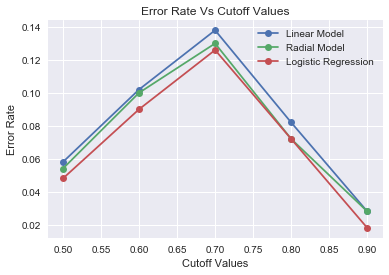

In [18]:
plt.plot(cutoff, best_error_linear, label = "Linear Model", marker = 'o')
plt.plot(cutoff, best_error_radial, label = "Radial Model", marker = 'o')
plt.plot(cutoff, best_error_logistic, label = "Logistic Regression", marker = 'o')
plt.title("Error Rate Vs Cutoff Values")
plt.xlabel('Cutoff Values')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

In [19]:
#Consolidated Table with Error Values
final_error_table = pd.concat([cutoff, best_error_logistic, error_linear, error_radial], axis=1)
final_error_table.columns = ["Cutoff", "Logistic Regression", "Linear SVM", "Radial SVM"]
final_error_table

,Cutoff,Logistic Regression,Linear SVM,Radial SVM
0,0.5,0.048,0.058,0.054
1,0.6,0.090,0.102,0.100
2,0.7,0.126,0.138,0.130
3,0.8,0.072,0.082,0.072
4,0.9,0.018,0.028,0.028


In [20]:
print('The minimum error is obtained in the logistic regression out of the three models above with the min error error: '
      + str(best_error_logistic.values[4])) 

The minimum error is obtained in the logistic regression out of the three models above with the min error error: [0.018]


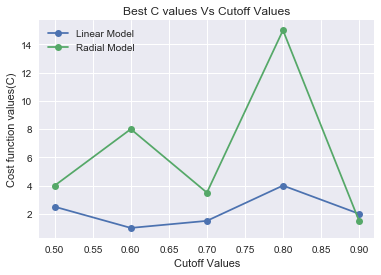

In [21]:
plt.plot(cutoff, c_linear, label = "Linear Model", marker = 'o')
plt.plot(cutoff, c_radial, label = "Radial Model", marker = 'o')
plt.title("Best C values Vs Cutoff Values")
plt.xlabel('Cutoff Values')
plt.ylabel('Cost function values(C)')
plt.legend()
plt.show()